In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from copy import deepcopy

from qibo.backends import construct_backend
from qibo import hamiltonians, Circuit, gates, set_backend
from qibo import gates, symbols
from qibo.gates import Unitary, CNOT, CZ
from qibo.symbols import X, Y, Z
from qibo import hamiltonians
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian

from db_doi.group_commutator_iteration import GroupCommutatorIteration, DoubleBracketRotationApproximationType
from db_doi.utils_XXZ_compilation import *

/home/marek/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from db_doi.utils_reporting import load_data, loading_simulation_data_path, fidelity_witness

HVA_results = {}
HVA_energies = load_data(loading_simulation_data_path() + f"energies")
for L in HVA_energies['Ls']:
    HVA_results[L] = load_data(loading_simulation_data_path() + f"XXZ_HVA_data_L{L}")
selected_circuits = load_data(loading_simulation_data_path() + f"selected_HVA_circuits")

In [3]:
selected_circuits

[{'L': 10, 'p': 3, 'E': np.float64(-16.956398519606598)},
 {'L': 12, 'p': 2, 'E': np.float64(-20.271913478084066)},
 {'L': 12, 'p': 4, 'E': np.float64(-20.5178799118926)},
 {'L': 14, 'p': 2, 'E': np.float64(-23.925901789100323)},
 {'L': 16, 'p': 4, 'E': np.float64(-27.43266393582254)},
 {'L': 18, 'p': 4, 'E': np.float64(-31.02535214409884)},
 {'L': 20, 'p': 5, 'E': np.float64(-34.46212549222226)},
 {'L': 20, 'p': 3, 'E': np.float64(-34.13462170936076)},
 {'L': 20, 'p': 6, 'E': np.float64(-34.541718281441824)}]

In [4]:
HVA_energies.keys()

dict_keys(['E0_L', 'E1_L', 'E_HVA_L', 'Ls', 'F_W_L'])

-34.13462170936076 -34.13462170936076 -34.72989333759567
DoubleBracketRotationApproximationType.group_commutator_reduced
--------------------------
Step 1
Step grid: [0.0005   0.007875 0.01525  0.022625 0.03    ]
Losses: [np.float64(-34.15952319960895), np.float64(-34.35983038580136), np.float64(-34.33191376290918), np.float64(-34.171063351898496), np.float64(-33.93341326914879)]
Optimal step: 0.007875
Minimum loss: -34.35983038580136


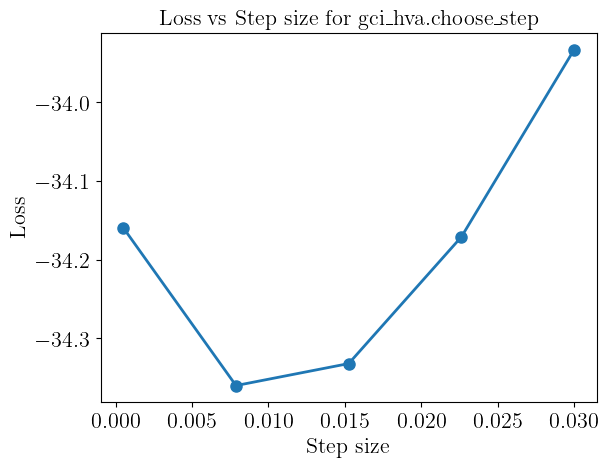

--------------------------
Step 2
Step grid: [0.0005   0.007875 0.01525  0.022625 0.03    ]
Losses: [np.float64(-34.368849417632376), np.float64(-34.45026761429401), np.float64(-34.46619015613774), np.float64(-34.4367745731312), np.float64(-34.36814421282758)]
Optimal step: 0.01525
Minimum loss: -34.46619015613774


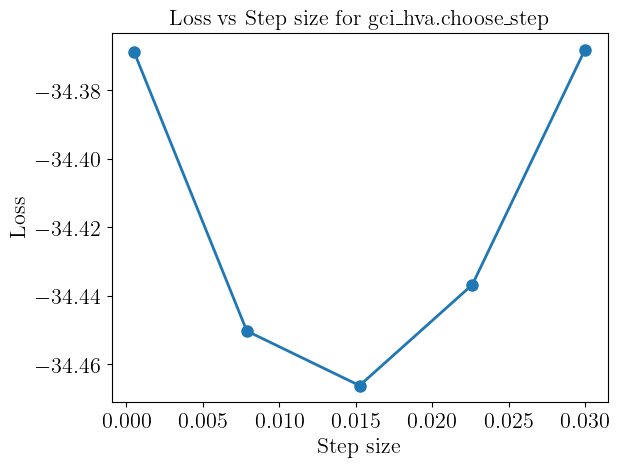

--------------------------
Step 3


In [ ]:
selection = selected_circuits[-2]
if 1:
    L = selection['L']
    p = selection['p']
    E0 = HVA_energies['E0_L'][L]
    E1 = HVA_energies['E1_L'][L]

    db_doi_warmstart_circuit = HVA_results[L][f"HVA_Nlayers_{p}"]['circuit']
    gci = GroupCommutatorIteration(XXZ_compilation_line(L), db_doi_warmstart_circuit, DoubleBracketRotationApproximationType.group_commutator_reduced )
    print(gci.loss(), HVA_results[L][f"HVA_Nlayers_{selection['p']}"]['E_HVA'], E0)
    print(gci.double_bracket_rotation_approximation_type)
    from collections import Counter
    two_qubit_counter = lambda circ: sum(1 for gate in circ.queue if len(gate.qubits) == 2)

    doi = hamiltonians.SymbolicHamiltonian( sum([ Z(i) for i in range(L)]))

    gci_results = {}
        
    db_doi_two_qubit_counts = [ two_qubit_counter(db_doi_warmstart_circuit) ]
    db_doi_energies =  [ gci.loss() ]
    db_doi_circuits = [deepcopy(db_doi_warmstart_circuit)]
    db_doi_fidelity_witness = [ fidelity_witness(gci.loss(),E0,E1)]
    for step in range(3):
        print("--------------------------")
        print(f"Step {step+1}")   

        step_grid = np.linspace(0.0005, 0.03, 5)
        s_opt, s_min, losses, _ = gci.choose_step(
            doi, step_grid=step_grid)
        print("Step grid:", step_grid)
        print("Losses:", losses)
        print(f"Optimal step: {s_opt}")
        print(f"Minimum loss: {s_min}")
        plt.figure()
        plt.plot(step_grid, losses, marker='o')
        plt.xlabel('Step size')
        plt.ylabel('Loss')
        plt.title('Loss vs Step size for gci_hva.choose_step')
        plt.show()

        gci(s_opt, doi)

        db_doi_two_qubit_counts.append( two_qubit_counter(gci.preparation_circuit))
        db_doi_energies.append(gci.loss())
        db_doi_circuits.append(deepcopy(gci.preparation_circuit))
        db_doi_fidelity_witness.append(fidelity_witness(gci.loss(),E0,E1))


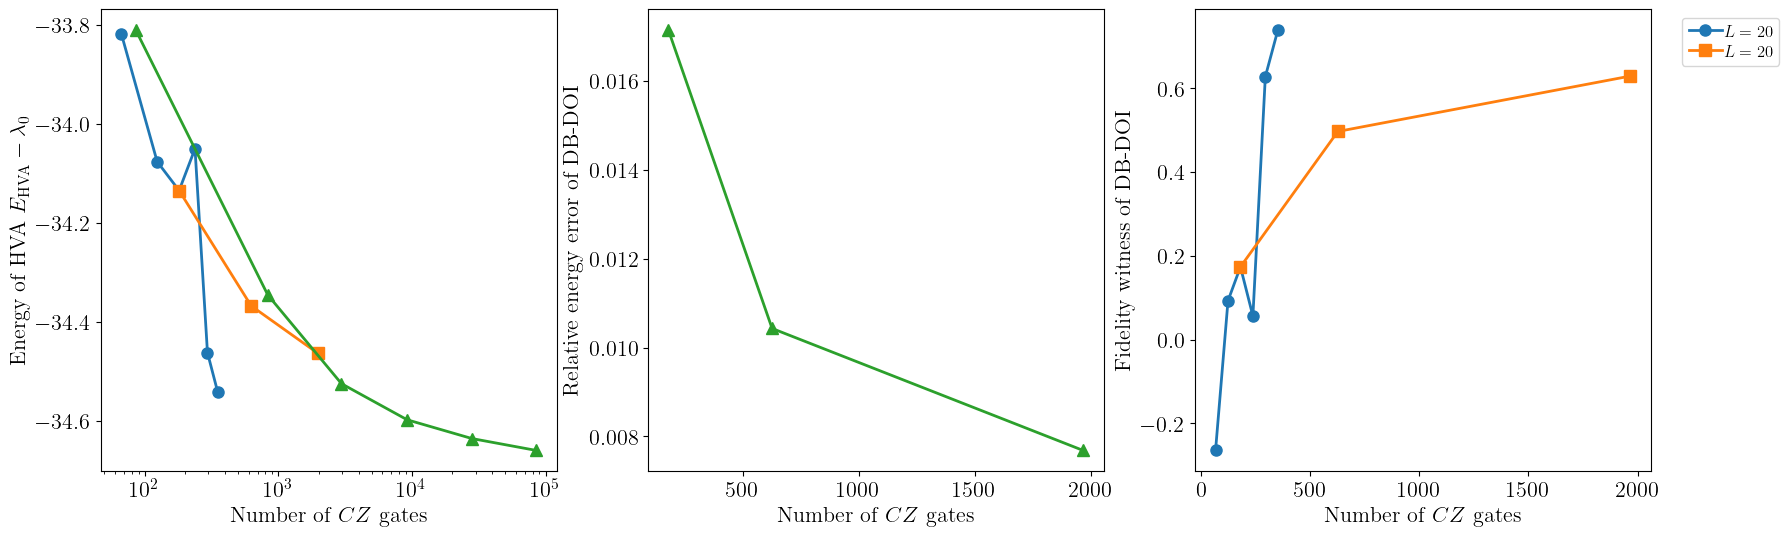

In [ ]:
from db_doi.utils_reporting import run_param_rc, load_data, loading_simulation_data_path
run_param_rc(16)

hva_two_qubit_counts = []
for p in range(1,7):
    hva_two_qubit_counts.append( two_qubit_counter(HVA_results[L][f"HVA_Nlayers_{p}"]['circuit']))

fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 6), 
                                     gridspec_kw={"width_ratios": [1, 1,1], "height_ratios": [1]})
markers = ['o', 's', '^', 'v', '<', '>', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

steps = [1,2,3,4,5,6]
#ax0.plot(steps, E_HVA_L[L]-E0_L[L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")

i=0
ax0.plot(hva_two_qubit_counts, HVA_energies['E_HVA_L'][L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
i=1
ax0.plot(db_doi_two_qubit_counts, db_doi_energies, color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
ax0.set_xlabel(r"Number of $CZ$ gates")
ax0.set_ylabel(r"Energy of HVA $E_{\mathrm{HVA}}-\lambda_0$")
i=2
ax0.plot(db_qite_two_qubit_counts,db_qite_energies, color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
ax0.set_xscale('log')
ax1.plot(db_doi_two_qubit_counts, abs(db_doi_energies- E0)/abs(E0), color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
ax1.set_xlabel(r"Number of $CZ$ gates")
ax1.set_ylabel(r"Relative energy error of DB-DOI")

i=0
ax2.plot(hva_two_qubit_counts, HVA_energies['F_W_L'][L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
i=1
ax2.plot(db_doi_two_qubit_counts, db_doi_fidelity_witness, color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")

ax2.set_xlabel(r"Number of $CZ$ gates")
ax2.set_ylabel(r"Fidelity witness of DB-DOI")       
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [12]:

path = "../simulation_results/Qrisp_simulations_DB_QITE_and_QPE/data/benchmarks_2nd_L=20_05-21-22"
db_qite_simulation_results = load_data(path)
print(db_qite_simulation_results[1]['optimal_energies'])

[np.float64(-33.811057507777605), np.float64(-34.34553897583189), np.float64(-34.52482487656907), np.float64(-34.59773436094439), np.float64(-34.63561951085654), np.float64(-34.65949516474965)]


In [25]:
db_qite_simulation_results[1].keys()

db_qite_two_qubit_counts = [db_qite_simulation_results[1]['circuit_data'][0][k]['cz'] for k in range(6)]
db_qite_energies = db_qite_simulation_results[1]['optimal_energies']

In [27]:
ax0.plot(db_qite_two_qubit_counts,db_qite_energies)
plt.show()

In [24]:
[db_qite_simulation_results[1]['circuit_data'][0][k]['cz'] for k in range(6)]


[86, 834, 2970, 9210, 28098, 84594]

In [22]:
[d['cz'] for d in db_qite_simulation_results[1]['circuit_data'][0].items()]

TypeError: tuple indices must be integers or slices, not str

In [7]:

print("Circuit analysis after:")
    print_gate_count_report(gci.preparation_circuit)  
    dbf_dbqa_two_qubit_counts.append( two_qubit_counter(gci.preparation_circuit))
    dbf_dbqa_energies.append( gci.loss() )  
data_collection[f"GCI_HVA_Nlayers_{nlayers}"] = { "gci": gci, "nlayers": nlayers, "energies": db_doi_energies,
                                                    "two_qubit_counts": db_doi_two_qubit_counts,
                                                    "circuit": db_doi_circuits }
gci_results[nlayers] = gci
data_collection["gci_results"] = gci_results

from db_doi.utils_reporting import save_data
#save_data(data_collection, simulation_data_path() + f"XXZ_GCI_x_HVA_data_L{L}")


IndentationError: unexpected indent (2280912442.py, line 2)

In [ ]:
HVA_circuit

{'nlayers': 3,
 'circuit': <qibo.models.circuit.Circuit at 0x7a5aca8bd9d0>,
 'E_HVA': np.float64(-16.956398519606598),
 't_HVA': array([-0.18928432, -0.09001695,  0.26665206,  0.11823337,  0.16660668,
         0.2379906 ])}

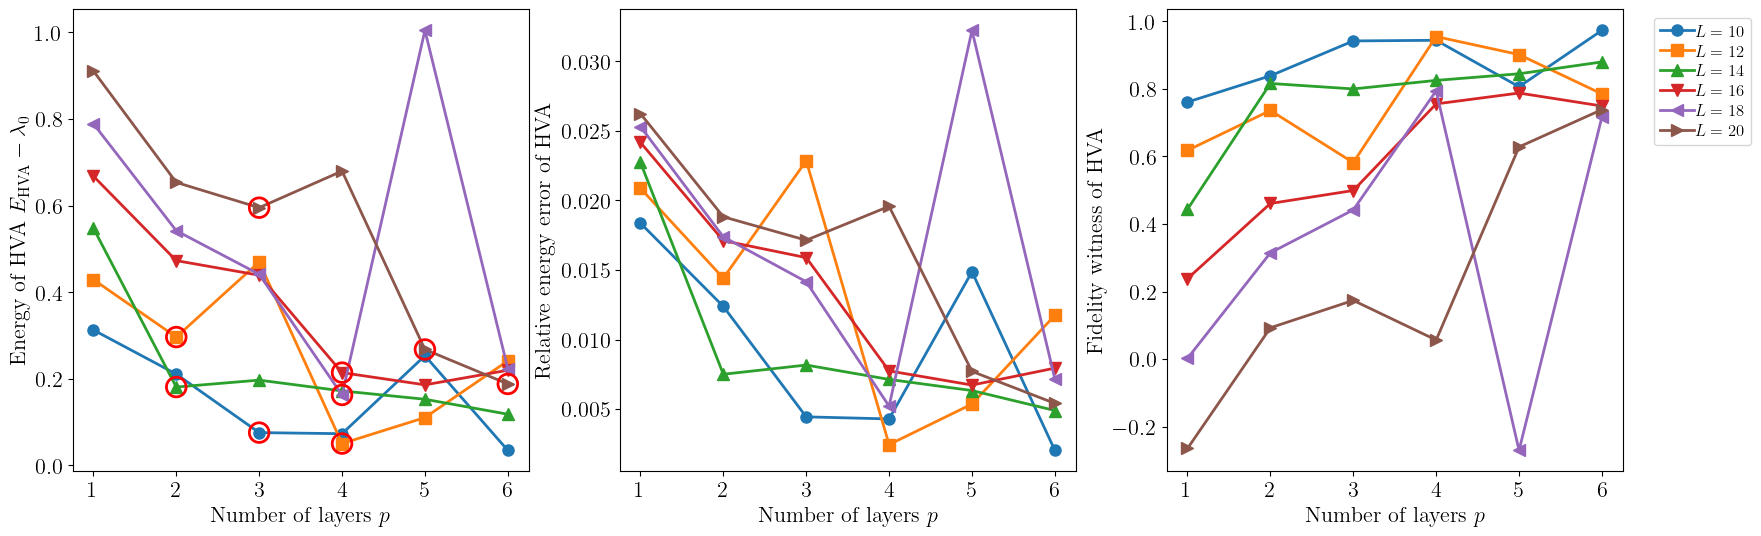

In [ ]:
from db_doi.utils_reporting import run_param_rc, load_data, loading_simulation_data_path
run_param_rc(16)


fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 6), 
                                     gridspec_kw={"width_ratios": [1, 1,1], "height_ratios": [1]})
markers = ['o', 's', '^', 'v', '<', '>', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,L in enumerate(Ls[2:]):

        steps = [1,2,3,4,5,6]
        ax0.plot(steps, E_HVA_L[L]-E0_L[L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
        ax0.set_xlabel(r"Number of layers $p$")
        ax0.set_ylabel(r"Energy of HVA $E_{\mathrm{HVA}}-\lambda_0$")

        ax1.plot(steps, abs(E_HVA_L[L]- E0_L[L])/abs(E0_L[L]), color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
        ax1.set_xlabel(r"Number of layers $p$")
        ax1.set_ylabel(r"Relative energy error of HVA")

        ax2.plot(steps, F_W_L[L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
        ax2.set_xlabel(r"Number of layers $p$")
        ax2.set_ylabel(r"Fidelity witness of HVA")       
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

selected_circuits =[
        {"L": 10, "p": 3, "E": E_HVA_L[10][2]},
        {"L": 12, "p": 2, "E": E_HVA_L[12][1]},
        {"L": 12, "p": 4, "E": E_HVA_L[12][3]},
        {"L": 14, "p": 2, "E": E_HVA_L[14][1]},
        {"L": 16, "p": 4, "E": E_HVA_L[16][3]},
        {"L": 18, "p": 4, "E": E_HVA_L[18][3]},
        {"L": 20, "p": 5, "E": E_HVA_L[20][4]},
        {"L": 20, "p": 3, "E": E_HVA_L[20][2]},
        {"L": 20, "p": 6, "E": E_HVA_L[20][5]},
]
save_data(selected_circuits, loading_simulation_data_path() + f"selected_HVA_circuits")
for selection  in selected_circuits:
        ax0.scatter(selection["p"], selection["E"]-E0_L[selection["L"]],
                facecolors='none',   # No fill inside the circle
                edgecolors='red',    # Red outline for the circle
                marker='o',          # Circle marker
                s=200,               # Size of the circle (adjust as needed)
                linewidth=2,         # Thickness of the circle's outline
                zorder=5)            # Ensure it's drawn on top
plt.savefig("pdfs_figures/HVA_overview.pdf")

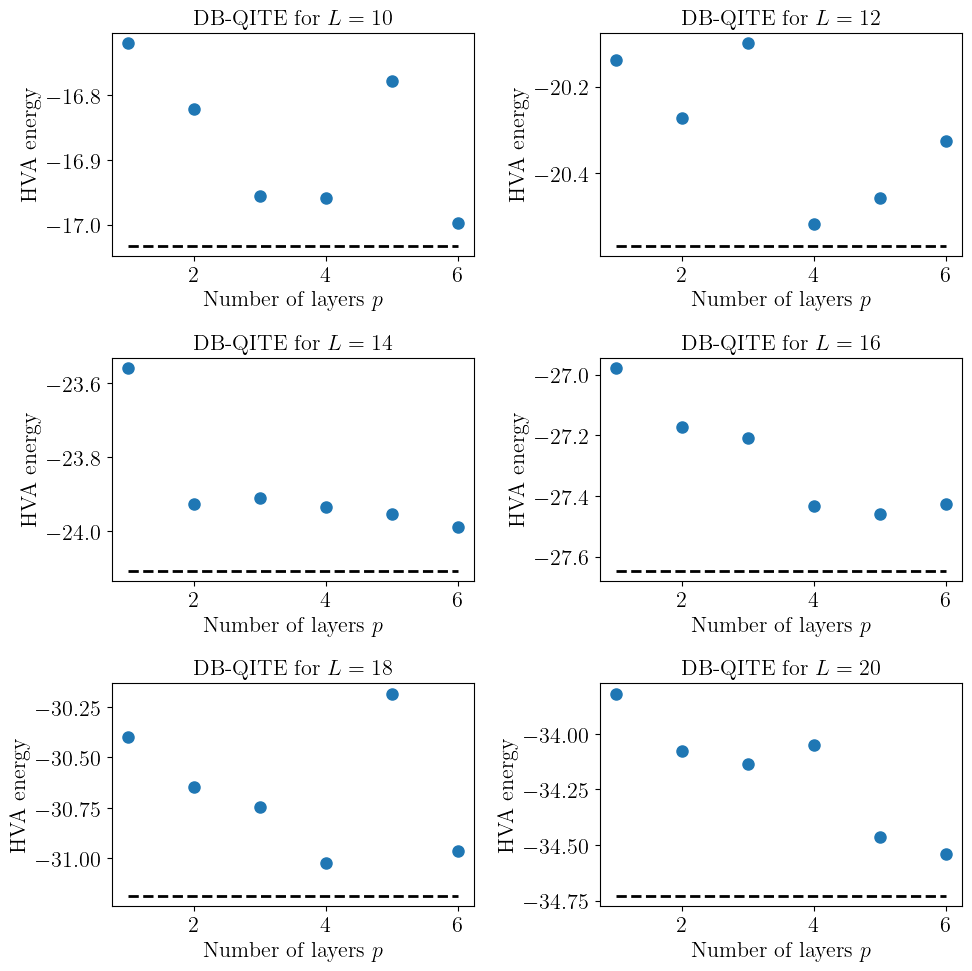

In [ ]:

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, ((ax_10, ax_12), 
      (ax_14, ax_16), 
      (ax_18, ax_20)) = plt.subplots(3, 2, figsize=(10, 10), 
                                     gridspec_kw={"width_ratios": [1, 1], "height_ratios": [1,1,1]})
def plot_HVA_results(ax,L):
        steps = [1,2,3,4,5,6]
        ax.plot(steps, E_HVA_L[L], 'o', label=f'Nlayers={nlayers}')
        ax.plot(steps, [E0_L[L]]*6, 'k--', label='E0')   
        ax.set_xlabel(r"Number of layers $p$")
        ax.set_ylabel(r"HVA energy")
        #ax.set_xticks(ticks = range(0, 6, 1))
        #ax.set_yticks(ticks = [-30,-31,-32,-33, -34,-35])
        #ax.legend(loc="center right", fontsize=15)
        ax.set_title(f"DB-QITE for $L={L}$")
plot_HVA_results(ax_10, 10)
plot_HVA_results(ax_12, 12)
plot_HVA_results(ax_14, 14)
plot_HVA_results(ax_16, 16)
plot_HVA_results(ax_18, 18)
plot_HVA_results(ax_20, 20)

plt.tight_layout()
#plt.savefig("plots/QITE_Heisenberg.pdf")
plt.show()

